In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

In [3]:


# Model Definition
class SimpleModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Data Preparation
def create_client_data(num_clients, dataset):
    client_data = []
    data_size = len(dataset) // num_clients
    indices = list(range(len(dataset)))
    for i in range(num_clients):
        subset_indices = indices[i * data_size:(i + 1) * data_size]
        client_dataset = Subset(dataset, subset_indices)
        client_data.append(DataLoader(client_dataset, batch_size=32, shuffle=True))
    return client_data

# FedAdam Aggregation
def fed_adam(models, global_model, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, m=None, v=None, t=1):
    global_dict = global_model.state_dict()
    if m is None:
        m, v = {}, {}
        for k in global_dict.keys():
            m[k], v[k] = torch.zeros_like(global_dict[k]), torch.zeros_like(global_dict[k])

    for k in global_dict.keys():
        updates = torch.stack([model.state_dict()[k] - global_dict[k] for model in models], 0).mean(0)
        m[k] = beta1 * m[k] + (1 - beta1) * updates
        v[k] = beta2 * v[k] + (1 - beta2) * updates.pow(2)

        m_hat = m[k] / (1 - beta1 ** t)
        v_hat = v[k] / (1 - beta2 ** t)

        global_dict[k] += lr * m_hat / (v_hat.sqrt() + epsilon)

    global_model.load_state_dict(global_dict)
    return global_model, m, v

# FedYogi Aggregation
def fed_yogi(models, global_model, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, m=None, v=None, t=1):
    global_dict = global_model.state_dict()
    if m is None:
        m, v = {}, {}
        for k in global_dict.keys():
            m[k], v[k] = torch.zeros_like(global_dict[k]), torch.zeros_like(global_dict[k])

    for k in global_dict.keys():
        updates = torch.stack([model.state_dict()[k] - global_dict[k] for model in models], 0).mean(0)
        m[k] = beta1 * m[k] + (1 - beta1) * updates
        v[k] = v[k] - (1 - beta2) * updates.pow(2) * torch.sign(v[k] - updates.pow(2))

        m_hat = m[k] / (1 - beta1 ** t)
        v_hat = v[k] / (1 - beta2 ** t)

        global_dict[k] += lr * m_hat / (v_hat.sqrt() + epsilon)

    global_model.load_state_dict(global_dict)
    return global_model, m, v

# Client-Side Training
def train_local_model(model, dataloader, epochs=1):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for data, target in dataloader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Global Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

# Federated Training Process (Updated)
def federated_training_comparison(client_data, global_model, test_loader, rounds=5, method="FedAdam"):
    accuracies = []

    # Initialize separate models
    global_model_copy = SimpleModel(input_size=global_model.fc[1].in_features, num_classes=global_model.fc[3].out_features)
    global_model_copy.load_state_dict(global_model.state_dict())

    m, v = None, None
    for r in range(1, rounds + 1):
        print(f"\nRound {r}/{rounds}")

        client_models = [SimpleModel(input_size=global_model.fc[1].in_features, num_classes=global_model.fc[3].out_features) for _ in range(len(client_data))]

        for i, dataloader in enumerate(client_data):
            client_models[i].load_state_dict(global_model_copy.state_dict())
            train_local_model(client_models[i], dataloader, epochs=1)

        # Perform aggregation based on chosen method
        if method == "FedAdam":
            global_model_copy, m, v = fed_adam(client_models, global_model_copy, m=m, v=v, t=r)
        elif method == "FedYogi":
            global_model_copy, m, v = fed_yogi(client_models, global_model_copy, m=m, v=v, t=r)

        # Evaluate model
        accuracies.append(evaluate_model(global_model_copy, test_loader))
        print(f"{method} Accuracy after round {r}: {accuracies[-1] * 100:.2f}%")

    return accuracies

# Dataset selection
def load_data(dataset_name):
    if dataset_name == "MNIST":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_name == "FashionMNIST":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        input_size = 28 * 28
        num_classes = 10
    elif dataset_name == "CIFAR10":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        input_size = 32 * 32 * 3
        num_classes = 10
    elif dataset_name == "SVHN":
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_data = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
        test_data = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
        input_size = 32 * 32 * 3
        num_classes = 10
    else:
        raise ValueError(f"Dataset '{dataset_name}' is not supported.")
    return train_data, test_data, input_size, num_classes

# Main Execution
#if __name__ == "__main__":
num_clients = 5
datasets_list = ["MNIST", "FashionMNIST", "CIFAR10", "SVHN"]
results = {"Round": list(range(1, 11))}

for dataset_name in datasets_list:
    train_data, test_data, input_size, num_classes = load_data(dataset_name)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    client_data = create_client_data(num_clients, train_data)
    global_model = SimpleModel(input_size=input_size, num_classes=num_classes)

    # Federated training with FedAdam and FedYogi
    accuracy_fedadam = federated_training_comparison(client_data, global_model, test_loader, rounds=10, method="FedAdam")
    accuracy_fedyogi = federated_training_comparison(client_data, global_model, test_loader, rounds=10, method="FedYogi")

    # Store results
    results[f"FedAdam - {dataset_name}"] = accuracy_fedadam
    results[f"FedYogi - {dataset_name}"] = accuracy_fedyogi

# Convert results to DataFrame and display
df_results = pd.DataFrame(results)
print(df_results)
    
    

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5375685.98it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 414198.60it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3896375.62it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2270623.21it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


Round 1/10
FedAdam Accuracy after round 1: 25.87%

Round 2/10
FedAdam Accuracy after round 2: 37.92%

Round 3/10
FedAdam Accuracy after round 3: 51.52%

Round 4/10
FedAdam Accuracy after round 4: 71.39%

Round 5/10
FedAdam Accuracy after round 5: 87.64%

Round 6/10
FedAdam Accuracy after round 6: 86.92%

Round 7/10
FedAdam Accuracy after round 7: 86.64%

Round 8/10
FedAdam Accuracy after round 8: 88.73%

Round 9/10
FedAdam Accuracy after round 9: 90.96%

Round 10/10
FedAdam Accuracy after round 10: 91.91%

Round 1/10
FedYogi Accuracy after round 1: 21.63%

Round 2/10
FedYogi Accuracy after round 2: 30.81%

Round 3/10
FedYogi Accuracy after round 3: 46.86%

Round 4/10
FedYogi Accuracy after round 4: 63.32%

Round 5/10
FedYogi Accuracy after round 5: 82.01%

Round 6/10
FedYogi Accuracy after round 6: 89.74%

Round 7/10
FedYogi Accuracy after round 7: 89.25%

Round 8/10
FedYogi Accuracy after round 8: 88.65%

Roun

100%|██████████| 26421880/26421880 [00:01<00:00, 14176882.20it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209373.63it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3872096.44it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10747773.52it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Round 1/10
FedAdam Accuracy after round 1: 66.53%

Round 2/10
FedAdam Accuracy after round 2: 72.38%

Round 3/10
FedAdam Accuracy after round 3: 78.32%

Round 4/10
FedAdam Accuracy after round 4: 81.73%

Round 5/10
FedAdam Accuracy after round 5: 83.00%

Round 6/10
FedAdam Accuracy after round 6: 84.30%

Round 7/10
FedAdam Accuracy after round 7: 84.79%

Round 8/10
FedAdam Accuracy after round 8: 85.11%

Round 9/10
FedAdam Accuracy after round 9: 85.02%

Round 10/10
FedAdam Accuracy after round 10: 85.16%

Round 1/10
FedYogi Accuracy after round 1: 66.86%

Round 2/10
FedYogi Accuracy after round 2: 74.02%

Round 3/10
FedYogi Accuracy after round 3: 79.10%

Round 4/10
FedYogi Accuracy after round 4: 81.26%

Round 5/10
FedYogi Accuracy after round 5: 82.92%

Round 6/10
FedYogi Accuracy after round 6: 83.85%

Round 7/10
FedYogi Accuracy after round 7: 84.31%

Round 8/10
FedYogi Accuracy after round 8

100%|██████████| 170498071/170498071 [00:06<00:00, 24470211.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Round 1/10
FedAdam Accuracy after round 1: 38.84%

Round 2/10
FedAdam Accuracy after round 2: 43.42%

Round 3/10
FedAdam Accuracy after round 3: 45.46%

Round 4/10
FedAdam Accuracy after round 4: 45.34%

Round 5/10
FedAdam Accuracy after round 5: 44.60%

Round 6/10
FedAdam Accuracy after round 6: 44.74%

Round 7/10
FedAdam Accuracy after round 7: 45.72%

Round 8/10
FedAdam Accuracy after round 8: 46.91%

Round 9/10
FedAdam Accuracy after round 9: 47.74%

Round 10/10
FedAdam Accuracy after round 10: 49.11%

Round 1/10
FedYogi Accuracy after round 1: 38.06%

Round 2/10
FedYogi Accuracy after round 2: 44.01%

Round 3/10
FedYogi Accuracy after round 3: 46.15%

Round 4/10
FedYogi Accuracy after round 4: 45.76%

Round 5/10
FedYogi Accuracy after round 5: 45.30%

Round 6/10
FedYogi Accuracy after round 6: 45.66%

Round 7/10
FedYogi Accuracy after round 7: 46.71%

Round 8/10
FedYogi Accuracy after round 8

100%|██████████| 182040794/182040794 [00:15<00:00, 11424705.47it/s]


100%|██████████| 64275384/64275384 [00:06<00:00, 9719302.01it/s]



Round 1/10
FedAdam Accuracy after round 1: 28.48%

Round 2/10
FedAdam Accuracy after round 2: 43.02%

Round 3/10
FedAdam Accuracy after round 3: 53.65%

Round 4/10
FedAdam Accuracy after round 4: 58.57%

Round 5/10
FedAdam Accuracy after round 5: 61.73%

Round 6/10
FedAdam Accuracy after round 6: 63.50%

Round 7/10
FedAdam Accuracy after round 7: 64.40%

Round 8/10
FedAdam Accuracy after round 8: 65.30%

Round 9/10
FedAdam Accuracy after round 9: 66.88%

Round 10/10
FedAdam Accuracy after round 10: 68.67%

Round 1/10
FedYogi Accuracy after round 1: 28.35%

Round 2/10
FedYogi Accuracy after round 2: 43.43%

Round 3/10
FedYogi Accuracy after round 3: 51.63%

Round 4/10
FedYogi Accuracy after round 4: 56.07%

Round 5/10
FedYogi Accuracy after round 5: 57.97%

Round 6/10
FedYogi Accuracy after round 6: 60.03%

Round 7/10
FedYogi Accuracy after round 7: 62.16%

Round 8/10
FedYogi Accuracy after round 8: 64.54%

Round 9/10
FedYogi Accuracy after round 9: 67.19%

Round 10/10
FedYogi Accuracy

In [4]:
df_results.to_csv('proj_results.csv')


Round 1/10
FedAdam Accuracy after round 1: 17.87%

Round 2/10
FedAdam Accuracy after round 2: 38.01%

Round 3/10
FedAdam Accuracy after round 3: 51.61%

Round 4/10
FedAdam Accuracy after round 4: 72.95%

Round 5/10
FedAdam Accuracy after round 5: 87.13%

Round 6/10
FedAdam Accuracy after round 6: 88.60%

Round 7/10
FedAdam Accuracy after round 7: 88.84%

Round 8/10
FedAdam Accuracy after round 8: 89.38%

Round 9/10
FedAdam Accuracy after round 9: 90.65%

Round 10/10
FedAdam Accuracy after round 10: 91.28%

Round 1/10
FedYogi Accuracy after round 1: 28.29%

Round 2/10
FedYogi Accuracy after round 2: 37.59%

Round 3/10
FedYogi Accuracy after round 3: 45.86%

Round 4/10
FedYogi Accuracy after round 4: 68.79%

Round 5/10
FedYogi Accuracy after round 5: 85.49%

Round 6/10
FedYogi Accuracy after round 6: 87.44%

Round 7/10
FedYogi Accuracy after round 7: 87.98%

Round 8/10
FedYogi Accuracy after round 8: 87.54%

Round 9/10
FedYogi Accuracy after round 9: 87.85%

Round 10/10
FedYogi Accuracy

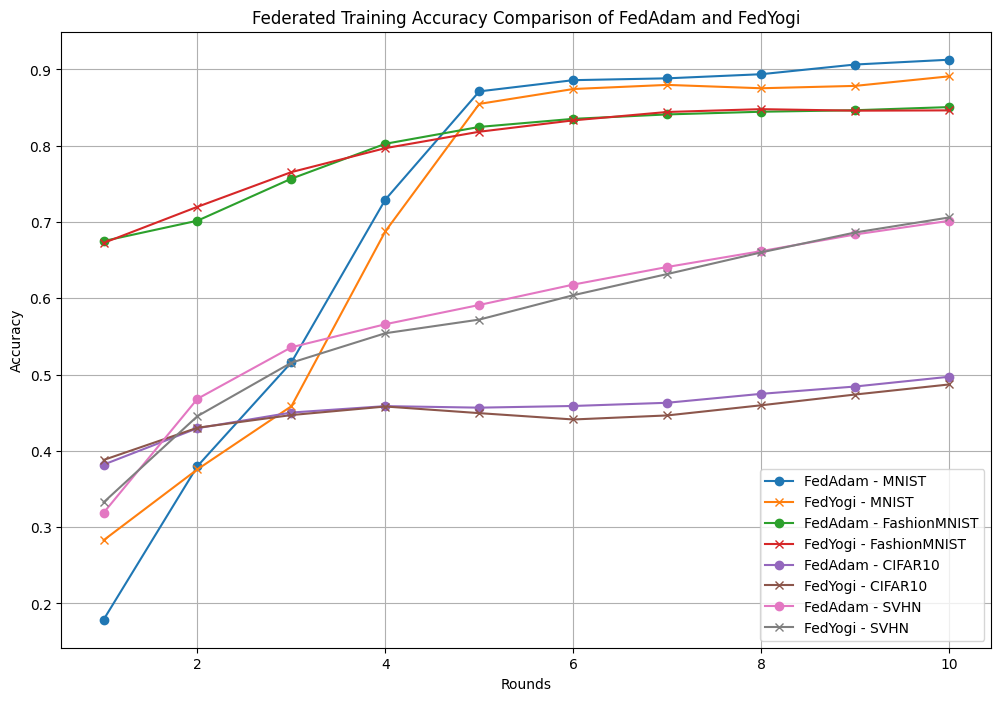

In [5]:
def plot_accuracies(results, datasets_list):
    plt.figure(figsize=(12, 8))
    rounds = results["Round"]

    for dataset_name in datasets_list:
        plt.plot(rounds, results[f"FedAdam - {dataset_name}"], label=f"FedAdam - {dataset_name}", marker='o')
        plt.plot(rounds, results[f"FedYogi - {dataset_name}"], label=f"FedYogi - {dataset_name}", marker='x')

    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.title("Federated Training Accuracy Comparison of FedAdam and FedYogi")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Main Execution
#if __name__ == "_main_":
num_clients = 5
datasets_list = ["MNIST", "FashionMNIST", "CIFAR10", "SVHN"]
results = {"Round": list(range(1, 11))}

for dataset_name in datasets_list:
    train_data, test_data, input_size, num_classes = load_data(dataset_name)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    client_data = create_client_data(num_clients, train_data)
    global_model = SimpleModel(input_size=input_size, num_classes=num_classes)

    # Federated training with FedAdam and FedYogi
    accuracy_fedadam = federated_training_comparison(client_data, global_model, test_loader, rounds=10, method="FedAdam")
    accuracy_fedyogi = federated_training_comparison(client_data, global_model, test_loader, rounds=10, method="FedYogi")

    # Store results
    results[f"FedAdam - {dataset_name}"] = accuracy_fedadam
    results[f"FedYogi - {dataset_name}"] = accuracy_fedyogi

# Convert results to DataFrame and display
df_results = pd.DataFrame(results)
print(df_results)

# Plot the results
plot_accuracies(results, datasets_list)